<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/YOLOv5_augment-ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5 inference_augment-ensemble**

###Setup

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco

/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco


In [3]:
%%writefile requirements.txt

# pip install -r requirements.txt

# Base ----------------------------------------
matplotlib>=3.2.2
numpy>=1.18.5
opencv-python-headless>=4.6.0.66
Pillow>=7.1.2
PyYAML>=5.3.1
##requests>=2.23.0
scipy>=1.4.1
# torch>=1.7.0
# torchvision>=0.8.1
tqdm>=4.41.0

# Logging -------------------------------------
##tensorboard>=2.4.1
# wandb

# Plotting ------------------------------------
##pandas>=1.1.4
##seaborn>=0.11.0

# Export --------------------------------------
# coremltools>=4.1  # CoreML export
# onnx>=1.9.0  # ONNX export
# onnx-simplifier>=0.3.6  # ONNX simplifier
# scikit-learn==0.19.2  # CoreML quantization
# tensorflow>=2.4.1  # TFLite export
# tensorflowjs>=3.9.0  # TF.js export

# Extras --------------------------------------
# albumentations>=1.0.3
# Cython  # for pycocotools https://github.com/cocodataset/cocoapi/issues/172
# pycocotools>=2.0  # COCO mAP
# roboflow
thop  # FLOPs computation

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
#最新バージョンでも動くので削除
# !pip install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install torchvision==0.11.2+cu113 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import glob
weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

num = 5
img_dir = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/data"
img = glob.glob(f"{img_dir}/*")[num]
img

img = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/runs/detect/exp/APAC_fko0078.jpg"

In [6]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


device = 'cpu'
#model = DetectMultiBackend(orig_weight_path, device="cpu", dnn=False)
# model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)

class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

def letterbox_image(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32): #Crescoのletterbox
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    # ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        # ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

    return im

def inference_top3(img_path, model):
    img_cv2 = cv2.imread(img_path)

    # Apply letterbox to the image
    img_cv2 = letterbox_image(img_cv2)
    #img_cv2 = cv2.resize(img_cv2,(640, 480))

    # Display the image using Matplotlib（表示させない場合はコメントアウトする）
    img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # Get current figure size
    fig_size = plt.gcf().get_size_inches()
    # Set new size (half the current size)
    plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

    plt.imshow(img_mpl)
    plt.axis('off')  # Turn off axis numbers
    plt.show()



    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    img_tensor /= 255
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    pred = model(img_tensor, visualize=False, augment=False)

    # multi_label=Trueにすることにより全クラスの値のlikelihoodを取得できる。数値が低いものが省略されないようconf_thres=0にしている。
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None , multi_label=True, max_det=1000)

    # 全てのクラスとlikelihoodのペアを取得
    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

    # likelihoodで降順にソート
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    # 上位3つのクラスとlikelihoodを出力
    print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        likelihood, class_num = class_likelihood_pairs[i]
        print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")

    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))

    return top_classes

Fusing layers... 
Model Summary: 213 layers, 7034398 parameters, 0 gradients, 15.8 GFLOPs


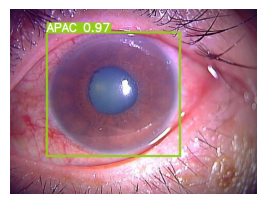

Top 3 Classes and Likelihoods:
Class 6 (APAC): Likelihood 0.97141
Class 4 (tumor): Likelihood 0.06582
Class 3 (scar): Likelihood 0.01356
[(6, 0.9714102149009705), (4, 0.0658194050192833), (3, 0.013558046892285347)]


In [7]:
#Simple inference
model = DetectMultiBackend(weight_path, device="cpu", dnn=False)
top_classes = inference_top3(img, model)
print(top_classes)

In [ ]:
top_classes[0][0]

6

In [8]:
num = 6
img_dir = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/data"
img = glob.glob(f"{img_dir}/*")[num]
img

'/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/data/scar_ehm0586_01.jpg'

Top 3 Classes and Likelihoods:
Class 3 (scar): Likelihood 0.88341
Class 3 (scar): Likelihood 0.00036
Class 3 (scar): Likelihood 0.00008
Number of boxes for class scar: 1


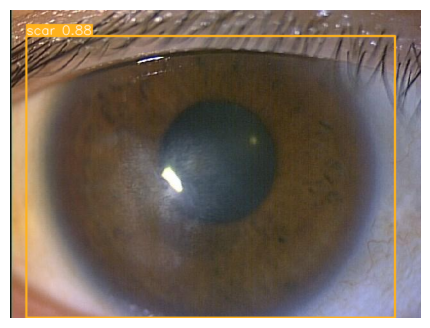

[(3, 0.8834111094474792), (3, 0.00035974857746623456), (3, 8.063701534410939e-05)]


In [28]:
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial/30.jpg"
top_classes = inference_top3(img_path, model)
print(top_classes)

### Bounding boxありバージョン

In [22]:
from models.common import DetectMultiBackend
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cpu'

class_names = {0: "infection", 1: "normal", 2: "non-infection", 3: "scar", 4: "tumor", 5: "deposit", 6: "APAC", 7: "lens opacity", 8: "bullous"}

def letterbox_image(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

    return im

def inference_top3(img_path, model, conf_thres_top3=0.0, conf_thres_bbox=0.25, iou_thres_bbox=0.45, max_bbox=1):
    img_cv2 = cv2.imread(img_path)
    img_cv2_orig = img_cv2.copy()

    # Apply letterbox to the image
    img_cv2_letterbox = letterbox_image(img_cv2)

    img_cv2_letterbox = img_cv2_letterbox.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2_letterbox = np.ascontiguousarray(img_cv2_letterbox)
    img_tensor = torch.from_numpy(img_cv2_letterbox).float()

    img_tensor /= 255
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    pred = model(img_tensor, visualize=False, augment=False)

    # Apply NMS with a low conf_thres to get top 3 classes
    pred_top3 = non_max_suppression(pred, conf_thres=conf_thres_top3, iou_thres=0.45, classes=None, agnostic=False, max_det=1000)

    # Get confidence-likelihood pairs for all classes
    class_likelihood_pairs = [(pred_top3[0][row][4].item(), int(pred_top3[0][row][5].item())) for row in range(len(pred_top3[0]))]

    # Sort by likelihood in descending order
    class_likelihood_pairs.sort(key=lambda x: (-x[0], class_names[x[1]]))

    # Output top 3 classes and likelihoods
    print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        if i < len(class_likelihood_pairs):
            likelihood, class_num = class_likelihood_pairs[i]
            print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")
        else:
            print("N/A")

    # Apply NMS with a higher conf_thres to get boxes for drawing
    pred_boxes = non_max_suppression(pred, conf_thres=conf_thres_bbox, iou_thres=iou_thres_bbox, classes=None, agnostic=False, max_det=1000)

    # Annotate the image with bounding box for top 1 class
    annotator = Annotator(img_cv2_orig, line_width=2, example=str(class_names))
    if len(class_likelihood_pairs) > 0:
        top1_class_num = class_likelihood_pairs[0][1]
        top1_boxes = []
        added_boxes = set()

        # Collect boxes and avoid duplicates
        for *box, conf, cls in pred_boxes[0]:
            if int(cls) == top1_class_num and tuple(box) not in added_boxes:
                top1_boxes.append(box)
                added_boxes.add(tuple(box))
                if len(top1_boxes) >= max_bbox:
                    break

        # Print the number of boxes collected
        print(f"Number of boxes for class {class_names[top1_class_num]}: {len(top1_boxes)}")

        # Sort boxes by area in descending order
        top1_boxes.sort(key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)

        # Scale coords back to original image size and annotate
        for i, xyxy in enumerate(top1_boxes):
            conf = [conf for *box, conf, cls in pred_boxes[0] if list(box) == xyxy][0]
            xyxy_orig = scale_coords(img_cv2_letterbox.shape[1:], torch.tensor(xyxy).view(1, 4), img_cv2_orig.shape).view(-1).tolist()
            label = f'{class_names[top1_class_num]} {conf:.2f}'
            annotator.box_label(xyxy_orig, label, color=colors(top1_class_num, True))

    # Display the annotated image
    img_mpl = cv2.cvtColor(annotator.result(), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    plt.imshow(img_mpl)
    plt.axis('off')
    plt.show()

    top_classes = [(class_num, likelihood) for likelihood, class_num in class_likelihood_pairs[:3]]
    return top_classes


In [ ]:
import os
import glob

# Directory containing images
img_dir = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/data"

# Get list of image paths
img_paths = glob.glob(os.path.join(img_dir, "*"))

# Initialize model
model = DetectMultiBackend(weight_path, device="cpu", dnn=False)

# Process each image in the directory
for img_path in img_paths:
    top_classes = inference_top3(img_path, model)
    print(top_classes)

# **Inference Maehara's 100 questions**
画像データ

sumaho: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_slit

slit: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_sumaho

結果CSV: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv

In [ ]:
img_dir_sumaho = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_slit"
img_dir_slit = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_sumaho"
csv_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv"

In [ ]:
import pandas as pd

# CSVファイルをPandas DataFrameとして読み込む
df = pd.read_csv(csv_dir)

# データフレームの内容を表示
print(df.head())


In [ ]:
import torch
from torchvision.transforms import v2 as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

augment_list = [None, "horizontalflip", "grayscale", "autocontrast", "rotate", "blur", "jpegcompression", "addnoise", "clahe", "sharpen", "gamma", "colorjitter", "tosepia","saturation"]

def inference_augment(img_path, model, augment):
    img_cv2 = cv2.imread(img_path)
    img_cv2 = letterbox_image(img_cv2)
    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]
    img_cv2 = np.ascontiguousarray(img_cv2)

    img_tensor = torch.from_numpy(img_cv2).float()
    img_tensor /= 255

    # Convert to uint8 if required for JPEG compression
    if augment == "jpegcompression":
        img_tensor = (img_tensor * 255).byte()

    # Apply augmentation based on the 'augment' argument
    if augment == "horizontalflip":
        img_tensor = T.functional.hflip(img_tensor)
    elif augment == "grayscale":
        img_tensor = T.functional.rgb_to_grayscale(img_tensor, num_output_channels=3)
    elif augment == "autocontrast":
        img_tensor = T.functional.autocontrast(img_tensor)
    elif augment == "rotate":
        img_tensor = T.functional.rotate(img_tensor, 10)
    elif augment == "blur":
        img_tensor = T.functional.gaussian_blur(img_tensor, kernel_size=(5, 9), sigma=(0.1, 5))
    elif augment == "jpegcompression":
        img_tensor = T.functional.jpeg(img_tensor, quality=30)
        img_tensor = img_tensor.float() / 255  # Convert back to float
    elif augment == "addnoise":
        noise = torch.randn(img_tensor.size()) * 0.1
        img_tensor = img_tensor + noise
        img_tensor = torch.clamp(img_tensor, 0, 1)
    elif augment == "clahe":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.CLAHE(p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255
    elif augment == "sharpen":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.Sharpen(p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255
    elif augment == "gamma":
        img_tensor = T.functional.adjust_gamma(img_tensor, gamma=1.8, gain=1.0)
    elif augment == "colorjitter":
        color_jitter = T.ColorJitter(brightness=0, contrast=0, saturation=1, hue=0)
        img_tensor = color_jitter(img_tensor)
    elif augment == "tosepia":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.ToSepia(p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255
    elif augment == "saturation":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=70, val_shift_limit=0, p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255


    img_augmented = img_tensor.numpy()
    img_augmented = img_augmented[::-1].transpose((1, 2, 0))
    img_augmented = (img_augmented * 255).astype(np.uint8)

    # show images

    # img_mpl_augmented = cv2.cvtColor(img_augmented, cv2.COLOR_BGR2RGB)
    # plt.figure(figsize=(4, 4))
    # plt.imshow(img_mpl_augmented)
    # plt.axis('off')
    # plt.show()

    img_tensor = torch.unsqueeze(img_tensor, 0)

    pred = model(img_tensor, visualize=False, augment=False)
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None, multi_label=True, max_det=1000)

    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(min(8, len(pred[0])))]
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    print(f"Top 3 Classes and Likelihoods (augment: {augment})")
    top_classes = []
    for i in range(min(1, len(class_likelihood_pairs))): #3つ表示したければ3に
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))
        print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")

    return top_classes

In [ ]:
# sample inference
img = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_slit/slit_090.jpg"
csv_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv"

augment_list = [None, "horizontalflip", "grayscale", "autocontrast", "rotate", "blur", "jpegcompression", "addnoise", "clahe", "sharpen", "gamma", "colorjitter", "tosepia","saturation"]

model = DetectMultiBackend(weight_path, device="cpu", dnn=False)

for augment in augment_list:
    top_classes = inference_augment(img, model, augment=augment)
    print(top_classes)


In [ ]:
df = pd.read_csv(csv_dir)

# Display the first few rows of the dataframe to understand its structure
df.head()

In [ ]:
import os

img_dir_sumaho = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_slit"
img_dir_slit = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_sumaho"
csv_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv"

# open csv
df = pd.read_csv(csv_dir)

# List all files in the given directories without extensions
files_sumaho = [os.path.splitext(file)[0] for file in os.listdir(img_dir_sumaho)]
files_slit = [os.path.splitext(file)[0] for file in os.listdir(img_dir_slit)]

# set model for inference
model = DetectMultiBackend(weight_path, device="cpu", dnn=False)

# set augment
augment_list = [None, "horizontalflip", "grayscale", "autocontrast", "rotate", "blur", "jpegcompression", "addnoise", "clahe", "sharpen", "gamma", "colorjitter", "tosepia","saturation"]

# Check each basename in the dataframe to see if it matches any files in the directories
for row, basename in enumerate(df["basename"]):
    if basename in files_sumaho:
        file_name = os.path.join(img_dir_sumaho, basename + ".jpg")
        print(f"groundtruth: {df['class_num'][row]}")
        for augment in augment_list:
            top1 = inference_augment(file_name, model, augment)
            top1_class, top1_prob = int(top1[0][0]), top1[0][1]
            augment_name = "original" if augment is None else augment
            df.at[row, augment_name] = top1_class
            df.at[row, augment_name + "_prob"] = top1_prob
    elif basename in files_slit:
        file_name = os.path.join(img_dir_slit, basename + ".jpg")
        print(f"groundtruth: {df['class_num'][row]}")
        for augment in augment_list:
            top1 = inference_augment(file_name, model, augment)
            top1_class, top1_prob = int(top1[0][0]), top1[0][1]
            augment_name = "original" if augment is None else augment
            df.at[row, augment_name] = top1_class
            df.at[row, augment_name + "_prob"] = top1_prob
    else:
        file_name = None
    print(file_name)

df.to_csv(csv_dir, index=False)
print(f"推論結果がCSVファイル '{csv_dir}' に上書き保存されました。")


#**Analyze enhance effects**

アンサンブルを行うことにより実際に精度が向上するかどうかを確認

In [ ]:
#元のモデルのマトリックス図を表示

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv"
maehara_data = pd.read_csv(file_path)

# Define class names dictionary
class_names = {0: "infection", 1: "normal", 2: "non-infection", 3: "scar", 4: "tumor", 5: "deposit", 6: "APAC", 7: "lens opacity", 8: "bullous"}

# Adding a new column to indicate if the image is from a smartphone or slit based on the basename
maehara_data['image_type'] = maehara_data['basename'].apply(lambda x: 'smartphone' if 'sumaho' in x else 'slit')

# Separate the data into smartphone and slit datasets
smartphone_data = maehara_data[maehara_data['image_type'] == 'smartphone']
slit_data = maehara_data[maehara_data['image_type'] == 'slit']

# Create confusion matrix for original class predictions versus true class_num for smartphone images (count)
confusion_matrix_smartphone_count = pd.crosstab(smartphone_data['class_num'], smartphone_data['original'], rownames=['True Class'], colnames=['Predicted Class'])

# Create confusion matrix for original class predictions versus true class_num for slit images (count)
confusion_matrix_slit_count = pd.crosstab(slit_data['class_num'], slit_data['original'], rownames=['True Class'], colnames=['Predicted Class'])

# Mapping the class names to the confusion matrices
confusion_matrix_smartphone_count_named = confusion_matrix_smartphone_count.rename(index=class_names, columns=class_names)
confusion_matrix_slit_count_named = confusion_matrix_slit_count.rename(index=class_names, columns=class_names)

# Plotting confusion matrix for smartphone images with class names
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_smartphone_count_named, annot=True, fmt='d', cbar=False, linewidths=.5, linecolor='black', cmap='gray_r')
plt.title('Confusion Matrix for Original Predictions (Smartphone Images)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Plotting confusion matrix for slit images with class names
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_slit_count_named, annot=True, fmt='d', cbar=False, linewidths=.5, linecolor='black', cmap='gray_r')
plt.title('Confusion Matrix for Original Predictions (Slit Images)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Create confusion matrix for original class predictions versus true class_num for all images (count)
confusion_matrix_all_count = pd.crosstab(maehara_data['class_num'], maehara_data['original'], rownames=['True Class'], colnames=['Predicted Class'])

# Mapping the class names to the confusion matrix
confusion_matrix_all_count_named = confusion_matrix_all_count.rename(index=class_names, columns=class_names)

# Plotting confusion matrix for all images with class names
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_all_count_named, annot=True, fmt='d', cbar=False, linewidths=.5, linecolor='black', cmap='gray_r')
plt.title('Confusion Matrix for Original Predictions (All Images)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [ ]:
import pandas as pd

#それぞれの画像処理について、各クラスの正解率を表示

# Load the CSV file
file_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv"
maehara_data = pd.read_csv(file_path)

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Define the transformations
transformations = ["original", "horizontalflip", "grayscale", "autocontrast", "rotate", "blur",
                   "jpegcompression", "addnoise", "clahe", "sharpen", "gamma", "colorjitter", "tosepia", "saturation"]

# Calculate accuracy for each transformation and each true class
class_labels = sorted(maehara_data['class_num'].unique())
accuracy_data = []

for class_label in class_labels:
    row = {'True Class': class_label}
    class_data = maehara_data[maehara_data['class_num'] == class_label]

    for transform in transformations:
        correct_predictions = class_data[class_data['class_num'] == class_data[transform]]
        accuracy = len(correct_predictions) / len(class_data) if len(class_data) > 0 else 0
        row[transform] = accuracy

    accuracy_data.append(row)

# Convert the list of dictionaries to a DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Display the DataFrame
accuracy_df



,True Class,original,horizontalflip,grayscale,autocontrast,rotate,blur,jpegcompression,addnoise,clahe,sharpen,gamma,colorjitter,tosepia,saturation
0,0,0.916667,0.916667,0.583333,0.916667,1.000000,0.916667,0.916667,1.000000,0.833333,1.000000,1.000000,0.916667,0.333333,0.916667
1,1,0.857143,0.928571,0.928571,0.928571,0.928571,0.857143,0.857143,0.500000,0.642857,1.000000,0.928571,0.928571,1.000000,0.928571
2,2,0.600000,0.700000,0.700000,0.600000,0.600000,0.500000,0.500000,0.200000,0.500000,0.400000,0.700000,0.600000,0.600000,0.500000
3,3,1.000000,1.000000,0.875000,1.000000,0.875000,1.000000,0.750000,0.375000,1.000000,0.625000,0.625000,1.000000,0.500000,0.875000
4,4,1.000000,1.000000,0.916667,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000
5,5,0.785714,0.785714,0.928571,0.857143,0.785714,0.785714,0.785714,0.142857,0.785714,0.714286,0.857143,0.785714,0.928571,0.785714
6,6,0.625000,0.625000,0.375000,0.500000,0.625000,0.625000,0.375000,0.375000,0.500000,0.500000,0.500000,0.625000,0.500000,0.625000
7,7,0.833333,0.750000,0.666667,0.833333,1.000000,0.500000,0.583333,0.500000,0.916667,0.833333,0.666667,0.833333,0.500000,0.833333
8,8,0.800000,0.800000,0.800000,0.800000,0.900000,1.000000,0.800000,0.700000,0.600000,0.700000,0.800000,0.800000,0.800000,0.800000


In [ ]:
# Load the CSV file
file_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100.csv"
maehara_data = pd.read_csv(file_path)

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Define the transformations
transformations = ["original", "horizontalflip", "grayscale", "autocontrast", "rotate", "blur",
                   "jpegcompression", "addnoise", "clahe", "sharpen", "gamma", "colorjitter", "tosepia", "saturation"]

# Calculate accuracy for each transformation and each true class
class_labels = sorted(maehara_data['class_num'].unique())
accuracy_data = []

for class_label in class_labels:
    row = {'True Class': class_label}
    class_data = maehara_data[maehara_data['class_num'] == class_label]

    for transform in transformations:
        correct_predictions = class_data[class_data['class_num'] == class_data[transform]]
        accuracy = len(correct_predictions) / len(class_data) if len(class_data) > 0 else 0
        row[transform] = accuracy

    accuracy_data.append(row)

# Convert the list of dictionaries to a DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Calculate overall accuracy for each transformation
overall_accuracy = {}

for transform in transformations:
    correct_predictions = maehara_data[maehara_data['class_num'] == maehara_data[transform]]
    accuracy = len(correct_predictions) / len(maehara_data)
    overall_accuracy[transform] = accuracy

overall_accuracy_df = pd.DataFrame(list(overall_accuracy.items()), columns=['Transformation', 'Overall Accuracy'])

# Display the DataFrames
accuracy_df_sorted = accuracy_df.sort_values(by='True Class')
accuracy_df_sorted, overall_accuracy_df


(   True Class  original  horizontalflip  grayscale  autocontrast    rotate  \
 0           0  0.916667        0.916667   0.583333      0.916667  1.000000   
 1           1  0.857143        0.928571   0.928571      0.928571  0.928571   
 2           2  0.600000        0.700000   0.700000      0.600000  0.600000   
 3           3  1.000000        1.000000   0.875000      1.000000  0.875000   
 4           4  1.000000        1.000000   0.916667      1.000000  1.000000   
 5           5  0.785714        0.785714   0.928571      0.857143  0.785714   
 6           6  0.625000        0.625000   0.375000      0.500000  0.625000   
 7           7  0.833333        0.750000   0.666667      0.833333  1.000000   
 8           8  0.800000        0.800000   0.800000      0.800000  0.900000   
 
        blur  jpegcompression  addnoise     clahe   sharpen     gamma  \
 0  0.916667         0.916667  1.000000  0.833333  1.000000  1.000000   
 1  0.857143         0.857143  0.500000  0.642857  1.000000  0

In [ ]:
accuracy_df_sorted

### 事後確率を利用して、アンサンブルinference

```
プロトコル
pred = 0 → そのまま
pred = 1 →tosepiaで判定。あるいはoriginal, tosepia, grayscaleでアンサンブル
pred = 2→そのまま
pred = 3→grayscaleで判定。
pred = 4→そのまま
pred = 5→horizontalflip, rotate, blurのアンサンブル
pred = 6→そのまま
pred = 7→claheで7以外だった場合にgrayscaleで判定
pred = 8→autocontrastで5を分別→clahe, gamma, sharpenで0を分別


```

In [ ]:
import os
import pandas as pd
import torch
from torchvision.transforms import v2 as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

augment_list = [None, "horizontalflip", "grayscale", "autocontrast", "rotate", "blur", "jpegcompression", "addnoise", "clahe", "sharpen", "gamma", "colorjitter", "tosepia","saturation"]
class_names = {0: "infection", 1: "normal", 2: "non-infection", 3: "scar", 4: "tumor", 5: "deposit", 6: "APAC", 7: "lens opacity", 8: "bullous"}


def apply_augmentation(img_tensor, augment):
    if augment == "horizontalflip":
        img_tensor = T.functional.hflip(img_tensor)
    elif augment == "grayscale":
        img_tensor = T.functional.rgb_to_grayscale(img_tensor, num_output_channels=3)
    elif augment == "autocontrast":
        img_tensor = T.functional.autocontrast(img_tensor)
    elif augment == "rotate":
        img_tensor = T.functional.rotate(img_tensor, 10)
    elif augment == "blur":
        img_tensor = T.functional.gaussian_blur(img_tensor, kernel_size=(5, 9), sigma=(0.1, 5))
    elif augment == "jpegcompression":
        img_tensor = T.functional.jpeg(img_tensor, quality=30)
        img_tensor = img_tensor.float() / 255
    elif augment == "addnoise":
        noise = torch.randn(img_tensor.size()) * 0.1
        img_tensor = img_tensor + noise
        img_tensor = torch.clamp(img_tensor, 0, 1)
    elif augment == "clahe":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.CLAHE(p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255
    elif augment == "sharpen":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.Sharpen(p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255
    elif augment == "gamma":
        img_tensor = T.functional.adjust_gamma(img_tensor, gamma=1.8, gain=1.0)
    elif augment == "colorjitter":
        color_jitter = T.ColorJitter(brightness=0, contrast=0, saturation=1, hue=0)
        img_tensor = color_jitter(img_tensor)
    elif augment == "tosepia":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.ToSepia(p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255
    elif augment == "saturation":
        img_cv2 = (img_tensor.numpy() * 255).astype(np.uint8)
        img_cv2 = img_cv2.transpose((1, 2, 0))
        transform = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=70, val_shift_limit=0, p=1.0)
        img_augmented = transform(image=img_cv2)['image']
        img_tensor = torch.from_numpy(img_augmented.transpose((2, 0, 1))).float() / 255

    return img_tensor

def inference_augment(img_path, model, augment):
    img_cv2 = cv2.imread(img_path)
    img_cv2 = letterbox_image(img_cv2)
    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]
    img_cv2 = np.ascontiguousarray(img_cv2)

    img_tensor = torch.from_numpy(img_cv2).float()
    img_tensor /= 255

    if augment is not None:
        img_tensor = apply_augmentation(img_tensor, augment)

    img_augmented = img_tensor.numpy()
    img_augmented = img_augmented[::-1].transpose((1, 2, 0))
    img_augmented = (img_augmented * 255).astype(np.uint8)

    ######################################
    # show images
    img_mpl_augmented = cv2.cvtColor(img_augmented, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_mpl_augmented)
    plt.axis('off')
    plt.show()
    #####################################

    img_tensor = torch.unsqueeze(img_tensor, 0)

    pred = model(img_tensor, visualize=False, augment=False)
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None, multi_label=True, max_det=1000)

    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(min(8, len(pred[0])))]
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    print(f"Top 3 Classes and Likelihoods (augment: {augment})")
    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))
        print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")

    return top_classes


def ensemble_predict(file_name, model):
    # オリジナルの予測を取得
    original_pred = inference_augment(file_name, model, None)
    original_class, original_prob = int(original_pred[0][0]), original_pred[0][1]
    print(f"オリジナルの予測: {class_names[original_class]}, 確率 {original_prob:.5f}")

    if original_class == 0:
        print("判定は infection でした。オリジナルの予測を返します")
        return original_class, original_prob

    elif original_class == 1:
        print("判定は normal でした。tosepia と grayscale の拡張を用いてアンサンブルを実行します")
        tosepia_pred = inference_augment(file_name, model, "tosepia")
        tosepia_class, tosepia_prob = int(tosepia_pred[0][0]), tosepia_pred[0][1]
        print(f"Tosepia の予測: {class_names[tosepia_class]}, 確率 {tosepia_prob:.5f}")

        grayscale_pred = inference_augment(file_name, model, "grayscale")
        grayscale_class, grayscale_prob = int(grayscale_pred[0][0]), grayscale_pred[0][1]
        print(f"Grayscale の予測: {class_names[grayscale_class]}, 確率 {grayscale_prob:.5f}")

        ensemble_classes = [original_class, tosepia_class, grayscale_class]
        ensemble_probs = [original_prob, tosepia_prob, grayscale_prob]

        # 多数決で判定
        ensemble_class = max(set(ensemble_classes), key=ensemble_classes.count)

        # 同数の場合は、確率が最大のものを選択
        if ensemble_classes.count(ensemble_class) < len(ensemble_classes) / 2:
            ensemble_class = ensemble_classes[ensemble_probs.index(max(ensemble_probs))]

        ensemble_prob = ensemble_probs[ensemble_classes.index(ensemble_class)]
        print(f"アンサンブルの結果を返します: {class_names[ensemble_class]}, 確率 {ensemble_prob:.5f}")

        return ensemble_class, ensemble_prob

    elif original_class == 2:
        print("判定は non-infection でした。オリジナルの予測を返します")
        return original_class, original_prob

    elif original_class == 3:
        print("判定は scar でした。grayscale の拡張を用いて予測を行います")
        grayscale_pred = inference_augment(file_name, model, "grayscale")
        grayscale_class, grayscale_prob = int(grayscale_pred[0][0]), grayscale_pred[0][1]
        print(f"Grayscale の予測を返します: {class_names[grayscale_class]}, 確率 {grayscale_prob:.5f}")

        return grayscale_class, grayscale_prob

    elif original_class == 4:
        print("判定は tumor でした。オリジナルの予測を返します")
        return original_class, original_prob

    elif original_class == 5:
        print("判定は deposit でした。horizontalflip, rotate, blur の拡張を用いてアンサンブルを実行します")
        hflip_pred = inference_augment(file_name, model, "horizontalflip")
        hflip_class, hflip_prob = int(hflip_pred[0][0]), hflip_pred[0][1]
        print(f"Horizontalflip の予測: {class_names[hflip_class]}, 確率 {hflip_prob:.5f}")

        rotate_pred = inference_augment(file_name, model, "rotate")
        rotate_class, rotate_prob = int(rotate_pred[0][0]), rotate_pred[0][1]
        print(f"Rotate の予測: {class_names[rotate_class]}, 確率 {rotate_prob:.5f}")

        blur_pred = inference_augment(file_name, model, "blur")
        blur_class, blur_prob = int(blur_pred[0][0]), blur_pred[0][1]
        print(f"Blur の予測: {class_names[blur_class]}, 確率 {blur_prob:.5f}")

        ensemble_classes = [hflip_class, rotate_class, blur_class]
        ensemble_probs = [hflip_prob, rotate_prob, blur_prob]

        # 多数決で判定
        ensemble_class = max(set(ensemble_classes), key=ensemble_classes.count)

        # 同数の場合は、確率が最大のものを選択
        if ensemble_classes.count(ensemble_class) < len(ensemble_classes) / 2:
            ensemble_class = ensemble_classes[ensemble_probs.index(max(ensemble_probs))]

        ensemble_prob = ensemble_probs[ensemble_classes.index(ensemble_class)]
        print(f"アンサンブルの結果: {class_names[ensemble_class]}, 確率 {ensemble_prob:.5f}")

        return ensemble_class, ensemble_prob

    elif original_class == 6:
        print("判定は APAC でした。オリジナルの予測を返します")
        return original_class, original_prob

    elif original_class == 7:
        print("判定は lens opacity でした。clahe の拡張を用いて予測を行います")
        clahe_pred = inference_augment(file_name, model, "clahe")
        clahe_class, clahe_prob = int(clahe_pred[0][0]), clahe_pred[0][1]
        print(f"CLAHE: {class_names[clahe_class]}, 確率 {clahe_prob:.5f}")

        if clahe_class != 7:
            print("CLAHE の予測が lens opacity ではありませんでした。grayscale の拡張を用いて予測を行います")
            grayscale_pred = inference_augment(file_name, model, "grayscale")
            grayscale_class, grayscale_prob = int(grayscale_pred[0][0]), grayscale_pred[0][1]
            print(f"Grayscale の予測を返します: {class_names[grayscale_class]}, 確率 {grayscale_prob:.5f}")

            return grayscale_class, grayscale_prob
        else:
            print("CLAHE の予測が lens opacity でした。それを返します")
            return clahe_class, clahe_prob

    elif original_class == 8:
        print("判定は bullous でした。autocontrast の拡張を用いて予測を行います")
        autocontrast_pred = inference_augment(file_name, model, "autocontrast")
        autocontrast_class, autocontrast_prob = int(autocontrast_pred[0][0]), autocontrast_pred[0][1]
        print(f"Autocontrast の予測: {class_names[autocontrast_class]}, 確率 {autocontrast_prob:.5f}")

        if autocontrast_class == 5:
            print("Autocontrast の予測は deposit でした。この予測を返します")
            return autocontrast_class, autocontrast_prob
        else:
            print("Autocontrast の予測が deposit ではありませんでした。clahe, gamma, sharpen の拡張を用いてアンサンブルを実行します")
            clahe_pred = inference_augment(file_name, model, "clahe")
            clahe_class, clahe_prob = int(clahe_pred[0][0]), clahe_pred[0][1]
            print(f"CLAHE の予測: {class_names[clahe_class]}, 確率 {clahe_prob:.5f}")

            gamma_pred = inference_augment(file_name, model, "gamma")
            gamma_class, gamma_prob = int(gamma_pred[0][0]), gamma_pred[0][1]
            print(f"Gamma の予測: {class_names[gamma_class]}, 確率 {gamma_prob:.5f}")

            sharpen_pred = inference_augment(file_name, model, "sharpen")
            sharpen_class, sharpen_prob = int(sharpen_pred[0][0]), sharpen_pred[0][1]
            print(f"Sharpen の予測: {class_names[sharpen_class]}, 確率 {sharpen_prob:.5f}")

            ensemble_classes = [clahe_class, gamma_class, sharpen_class]
            ensemble_probs = [clahe_prob, gamma_prob, sharpen_prob]

            # 多数決で判定
            ensemble_class = max(set(ensemble_classes), key=ensemble_classes.count)

            # 同数の場合は、確率が最大のものを選択
            if ensemble_classes.count(ensemble_class) < len(ensemble_classes) / 2:
                ensemble_class = ensemble_classes[ensemble_probs.index(max(ensemble_probs))]

            ensemble_prob = ensemble_probs[ensemble_classes.index(ensemble_class)]
            print(f"アンサンブルの結果: {class_names[ensemble_class]}, 確率 {ensemble_prob:.5f}")

            if ensemble_class == 0:
                print(f"アンサンブルの予測結果が infectionなので、それを返します")
                return ensemble_class, ensemble_prob
            else:
                print(f"アンサンブルの予測結果がinfectionではありませんでした。オリジナルの予測を返します")
                return original_class, original_prob

In [ ]:
img_dir_sumaho = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_slit"
img_dir_slit = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_sumaho"
csv_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100_ensemble.csv"

# open csv
df = pd.read_csv(csv_dir)

# List all files in the given directories without extensions
files_sumaho = [os.path.splitext(file)[0] for file in os.listdir(img_dir_sumaho)]
files_slit = [os.path.splitext(file)[0] for file in os.listdir(img_dir_slit)]

# set model for inference
model = DetectMultiBackend(weight_path, device="cpu", dnn=False)

# Check each basename in the dataframe to see if it matches any files in the directories
for row, basename in enumerate(df["basename"]):

    if basename in files_sumaho:
        file_name = os.path.join(img_dir_sumaho, basename + ".jpg")
    elif basename in files_slit:
        file_name = os.path.join(img_dir_slit, basename + ".jpg")
    else:
        file_name = None

    if file_name is not None:
        print(f"groundtruth: {df['class_num'][row]}")
        ensemble_class, ensemble_prob = ensemble_predict(file_name, model)
        df.at[row, "ensemble_pred"] = ensemble_class
        df.at[row, "ensemble_prob"] = ensemble_prob
        print("")
    else:
        print(file_name)

df.to_csv(csv_dir, index=False)
print(f"推論結果がCSVファイル '{csv_dir}' に上書き保存されました。")

In [ ]:
#推論結果のマトリックス表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the CSV file
file_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara100_ensemble.csv"
data = pd.read_csv(file_path)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title, class_names, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[class_names[i] for i in sorted(class_names.keys())],
                yticklabels=[class_names[i] for i in sorted(class_names.keys())])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.show()

# Extracting the true labels and predicted labels
true_labels = data['class_num']
pred_labels = data['ensemble_pred']

# Create and plot confusion matrix for all data
conf_matrix_all = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(conf_matrix_all, 'Confusion Matrix: True vs Predicted Labels', class_names, figsize=(6, 6))

# Separate data into 'sumaho' and 'slit' based on basename containing 'sumaho' or 'slit'
sumaho_data = data[data['basename'].str.contains('sumaho', na=False)]
slit_data = data[data['basename'].str.contains('slit', na=False)]

# Calculate and plot confusion matrices for sumaho and slit
conf_matrix_sumaho = confusion_matrix(sumaho_data['class_num'], sumaho_data['ensemble_pred'], labels=sorted(class_names.keys()))
plot_confusion_matrix(conf_matrix_sumaho, 'Confusion Matrix of Ensemble Predictions (Sumaho)', class_names)

conf_matrix_slit = confusion_matrix(slit_data['class_num'], slit_data['ensemble_pred'], labels=sorted(class_names.keys()))
plot_confusion_matrix(conf_matrix_slit, 'Confusion Matrix of Ensemble Predictions (Slit)', class_names)


#**Inference Maehara's 240 questions (100問は除外)**

In [ ]:
sumaho_img_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_resized"
slit_img_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_resized"
test_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の100問_augmentation_ensemble/maehara184new.csv"

In [ ]:
import os
import pandas as pd

#df = pd.read_csv(test_csv_path)
#df = pd.read_csv(test_csv_path, encoding='shift_jis')
#df = pd.read_csv(test_csv_path, encoding='cp932')
df = pd.read_csv(test_csv_path, encoding='ISO-8859-1')



# Create the full path by combining the base directory, basename, and ".jpg"
df['image_path'] = sumaho_img_dir + "/" + df['basename'] + ".jpg"

# Display the first few rows to verify the new column
df[['basename', 'image_path']].head()


### sumaho_ensemble

In [ ]:
for index, row in df.iterrows():
    basename = row['basename']
    image_path = f"{sumaho_img_dir}/{basename}.jpg"

    # ensemble_predict関数を呼び出して推論を実行
    ensemble_class, ensemble_prob = ensemble_predict(image_path, model)

    # 推論結果をデータフレームに格納
    df.at[index, 'sumaho_ensemble'] = int(ensemble_class)

# 更新されたデータフレームをCSVファイルに上書き保存
df.to_csv(test_csv_path, index=False)

### sumaho_original

In [ ]:
for index, row in df.iterrows():
    basename = row['basename']
    image_path = f"{sumaho_img_dir}/{basename}.jpg"

    # inference_augment関数を呼び出して、augment=Noneで推論を実行
    original_pred = inference_augment(image_path, model, None)
    original_class, original_prob = original_pred[0]

    # 推論結果をデータフレームに格納
    df.at[index, 'sumaho_orig'] = original_class

# 更新されたデータフレームをCSVファイルに上書き保存
df.to_csv(test_csv_path, index=False)

### slit_ensemble

In [ ]:
for index, row in df.iterrows():
    basename = row['basename']
    image_path = f"{slit_img_dir}/{basename}.jpg"

    # ensemble_predict関数を呼び出して推論を実行
    ensemble_class, ensemble_prob = ensemble_predict(image_path, model)

    # 推論結果をデータフレームに格納
    df.at[index, 'slit_ensemble'] = int(ensemble_class)

# 更新されたデータフレームをCSVファイルに上書き保存
df.to_csv(test_csv_path, index=False)

### slit_original

In [ ]:
for index, row in df.iterrows():
    basename = row['basename']
    image_path = f"{slit_img_dir}/{basename}.jpg"

    # inference_augment関数を呼び出して、augment=Noneで推論を実行
    original_pred = inference_augment(image_path, model, None)
    original_class, original_prob = original_pred[0]

    # 推論結果をデータフレームに格納
    df.at[index, 'slit_orig'] = original_class

# 更新されたデータフレームをCSVファイルに上書き保存
df.to_csv(test_csv_path, index=False)

#**Inference Maehara's 240 questions**

In [ ]:
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara100/maehara100_slit"
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/corr_table_all.csv"

In [ ]:
import pandas as pd
pd.options.display.max_rows = 300

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)
df['class_num'] = df['class_num'].astype(int)

# Add empty columns for top1, top1_prob, top2, top2_prob, top3, top3_prob
for col in ['top1', 'top1_prob', 'top2', 'top2_prob', 'top3', 'top3_prob']:
    df[col] = None

# Show the first few rows to verify the new columns
df.head()
df



In [ ]:
import os
def update_dataframe_with_inference_results(df, image_dir, model):
    # Loop through all images in the directory
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        # Perform inference on the image using inference_top3 function
        print("")
        print(f"{os.path.basename(img_name)}")
        top_classes = inference_top3(img_path, model)

        # Get the basename without the file extension
        basename = os.path.splitext(img_name)[0]
        # Find the row in the DataFrame that matches the image basename
        row_index = df[df['basename'] == basename].index

        if not row_index.empty:
            # Unpack the top classes and probabilities
            top1, top1_prob = top_classes[0]
            top2, top2_prob = top_classes[1]
            top3, top3_prob = top_classes[2]

            # Update the DataFrame
            df.at[row_index[0], 'top1'] = top1
            df.at[row_index[0], 'top1_prob'] = top1_prob
            df.at[row_index[0], 'top2'] = top2
            df.at[row_index[0], 'top2_prob'] = top2_prob
            df.at[row_index[0], 'top3'] = top3
            df.at[row_index[0], 'top3_prob'] = top3_prob

        # Optionally print the top classes for debugging or verification
        print(top_classes)
    return df

df = update_dataframe_with_inference_results(df, image_dir, model)
df

In [ ]:
# Save the updated DataFrame to a new CSV file
updated_csv_path = '/content/updated_corr_table_all.csv'
df.to_csv(updated_csv_path, index=False)

###**Maehara_total (250+100)_dataset**

In [ ]:
import pandas as pd
import os

def update_dataframe_with_inference_results(df, image_dir, model):
    # 指定されたディレクトリ内の画像ファイル名を取得
    image_names = os.listdir(image_dir)

    # 画像ファイル名を数値部分に基づいてソート
    sorted_image_names = sorted(image_names, key=lambda x: int(os.path.splitext(x)[0]))

    # ソートされた画像ファイル名を反復処理
    for img_name in sorted_image_names:
        # 画像ファイルのパスを作成
        img_path = os.path.join(image_dir, img_name)

        # inference_top3関数を使用して画像の推論を実行
        print("")
        print(f"{os.path.basename(img_name)}")
        top_classes = inference_top3(img_path, model)

        # 画像ファイル名から行インデックスを取得
        row_index = int(os.path.splitext(img_name)[0]) - 1
        if 0 <= row_index < len(df):
            # 上位のクラスと確率をアンパック
            top1, top1_prob = top_classes[0]
            top2, top2_prob = top_classes[1]
            top3, top3_prob = top_classes[2]

            # DataFrameを更新
            df.at[row_index, 'top1'] = top1
            df.at[row_index, 'top1_prob'] = top1_prob
            df.at[row_index, 'top2'] = top2
            df.at[row_index, 'top2_prob'] = top2_prob
            df.at[row_index, 'top3'] = top3
            df.at[row_index, 'top3_prob'] = top3_prob

            # デバッグや検証のために上位のクラスを出力（オプション）
            print(top_classes)

    return df

def process_data(image_dir, csv_path, updated_csv_path):
    # 表示する最大行数を設定
    pd.options.display.max_rows = 300

    # CSVファイルをDataFrameとして読み込む
    df = pd.read_csv(csv_path)
    # 'class_num'列をint型に変換
    df['class_num'] = df['class_num'].astype(int)

    # 新しい列（top1, top1_prob, top2, top2_prob, top3, top3_prob）を追加し、初期値をNoneに設定
    for col in ['top1', 'top1_prob', 'top2', 'top2_prob', 'top3', 'top3_prob']:
        df[col] = None

    # 新しい列を確認するために最初の数行を表示
    df.head()

    # update_dataframe_with_inference_results関数を呼び出してDataFrameを更新
    df = update_dataframe_with_inference_results(df, image_dir, model)

    # 更新後のDataFrameを新しいCSVファイルに保存
    df.to_csv(updated_csv_path, index=False)

In [ ]:
# パスを指定
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_slit_total.csv"
updated_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_slit_total_updated.csv"

# データ処理を実行
process_data(image_dir, csv_path, updated_csv_path)

In [ ]:
# パスを指定
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial"
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_sumaho_total.csv"
updated_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_sumaho_total_updated.csv"

# データ処理を実行
process_data(image_dir, csv_path, updated_csv_path)

In [ ]:
import pandas as pd

def calculate_accuracy(updated_csv_path):
    # 更新後のCSVファイルを読み込む
    df = pd.read_csv(updated_csv_path)

    # クラスごとの正解率を計算
    class_accuracy = {}
    for class_num in df['class_num'].unique():
        class_df = df[df['class_num'] == class_num]
        correct_predictions = (class_df['class_num'] == class_df['top1']).sum()
        total_predictions = len(class_df)
        accuracy = correct_predictions / total_predictions
        class_accuracy[class_num] = accuracy

    # 全体の正解率を計算
    overall_correct_predictions = (df['class_num'] == df['top1']).sum()
    overall_total_predictions = len(df)
    overall_accuracy = overall_correct_predictions / overall_total_predictions

    return class_accuracy, overall_accuracy

def display_accuracy(class_accuracy, overall_accuracy):
    # クラス番号を0から順番に並べ替え
    sorted_classes = sorted(class_accuracy.keys())

    # クラスごとの正解率を表示
    print("クラスごとの正解率:")
    for class_num in sorted_classes:
        accuracy = class_accuracy[class_num]
        print(f"クラス {class_num}: {accuracy:.2f}")

    # 全体の正解率を表示
    print(f"\n全体の正解率: {overall_accuracy:.2f}")

# パスを指定
updated_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_sumaho_total_updated.csv"

# 正解率を計算
class_accuracy, overall_accuracy = calculate_accuracy(updated_csv_path)

# 正解率を表示
display_accuracy(class_accuracy, overall_accuracy)

# 必要な部分だけ抜粋

#**Inference using Cornea journal dataset**

In [ ]:
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"
excel_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/corneaのスマホ判定_滝先生.xlsx"
baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
mixed_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/2.始めから混合データセットで学習/last.pt"
finetune_mixed_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/3.CorneAIを混合データセットで学習/last.pt"
finetune_100ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/100epoch/last.pt"
finetune_150ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/150epoch/last.pt"
finetune_200ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/200epoch/last.pt"
finetune_250ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/250epoch/last.pt"
finetune_300ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/300epoch/last.pt"
finetune_350ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/350epoch/last.pt"
finetune_400ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/400epoch/last.pt"

In [ ]:
import pandas as pd

# Read the Excel file starting from row 13 (which is indexed as 12 in Python) for headers
df = pd.read_excel(excel_path, header=12)

# Display the first few rows of the dataframe
df.head()

In [ ]:
import os
import pandas as pd

# Assuming df is your DataFrame and it's already loaded
# df = pd.read_csv('your_dataframe.csv')  # Replace with your DataFrame loading method

# Directory path
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"

class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

# Define the columns for the new DataFrame
columns = ["image_num", "class"]

# Create an empty DataFrame with the specified columns
cornea_journal_df = pd.DataFrame(columns=columns)

# Iterating over each file in the directory
for filename in os.listdir(images_dir):
    if filename.endswith(".png"):
        # Extracting the numeric part (image number) from the filename
        image_num = int(filename.split('.')[0])

        # Match with the DataFrame and extract 'クラス' value
        matched_row = df[df['Number'] == image_num]
        if not matched_row.empty:
            class_value = matched_row['クラス'].iloc[0]
            # Creating a new row as a DataFrame
            row_data = pd.DataFrame({"image_num": [image_num], "class": [class_value], "class_name": [class_names[class_value]]})
            # Concatenating the new row DataFrame with the main DataFrame
            cornea_journal_df = pd.concat([cornea_journal_df, row_data], ignore_index=True)

# Sort the DataFrame by the image_num column
cornea_journal_df.sort_values(by='image_num', inplace=True)

# Displaying the sorted DataFrame
print(cornea_journal_df)


In [ ]:
# 画像のクラスを確認
# Getting the distribution of the 'class' column and sorting by class values
class_distribution = cornea_journal_df['class'].value_counts().sort_index()

# Displaying the distribution
print(class_distribution)

0    46
1     7
2     9
3    31
4    33
5    32
8     4
Name: class, dtype: int64


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# Baseline model
# Modify the loop to update DataFrame
model = DetectMultiBackend(baseline_weight_path, device="cpu", dnn=False)
for num in cornea_journal_df["image_num"]:
    img = f"{images_dir}/{num}.png"
    top3_results = inference_top3(img, model)

    # Update the DataFrame with the results
    for i, (class_num, likelihood) in enumerate(top3_results):
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_baseline'] = class_names[class_num]
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_baseline_likelihood'] = likelihood

In [ ]:
"""
# New model
baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
mixed_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/2.始めから混合データセットで学習/last.pt"
finetune_mixed_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/2.始めから混合データセットで学習/last.pt"
finetune_100ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/100epoch/last.pt"
finetune_150ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/150epoch/last.pt"
finetune_200ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/200epoch/last.pt"
finetune_250ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/250epoch/last.pt"
finetune_300ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/300epoch/last.pt"
finetune_350ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/350epoch/last.pt"
finetune_400ep_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/400epoch/last.pt"
"""

# Modify the loop to update DataFrame
model = DetectMultiBackend(mixed_weight_path, device="cpu", dnn=False)
for num in cornea_journal_df["image_num"]:
    img = f"{images_dir}/{num}.png"
    top3_results = inference_top3(img, model)

    # Update the DataFrame with the results
    for i, (class_num, likelihood) in enumerate(top3_results):
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_new'] = class_names[class_num]
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_new_likelihood'] = likelihood

In [ ]:
cornea_journal_df

In [ ]:
# Define the destination path for the CSV file
dst_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/baseline_to_mixed.csv"

# Save the DataFrame to the CSV file
cornea_journal_df.to_csv(dst_path, index=False)

#***Analyze_results***

In [ ]:
import pandas as pd

# Assuming csv_path is the file path to your CSV file
#csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/compare_accuracy.csv"
csv_path = dst_path

# Read the CSV file using pandas
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df.head()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the class names order
class_names_order = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# Create a confusion matrix for top1_baseline
cm_baseline = confusion_matrix(df['class_name'], df['top1_baseline'], labels=class_names_order)

# Create a confusion matrix for top1_new
cm_new = confusion_matrix(df['class_name'], df['top1_new'], labels=class_names_order)


# Plot for top1_baseline
fig1, ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_baseline, annot=True, ax=ax1, fmt='d', cmap='Blues')
ax1.set_title('Confusion Matrix for top1_baseline')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_xticklabels(class_names_order, rotation=45)
ax1.set_yticklabels(class_names_order, rotation=45)
plt.show()

# Plot for top1_new
fig2, ax2 = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_new, annot=True, ax=ax2, fmt='d', cmap='Greens')
ax2.set_title('Confusion Matrix for top1_new')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')
ax2.set_xticklabels(class_names_order, rotation=45)
ax2.set_yticklabels(class_names_order, rotation=45)
plt.show()


In [ ]:
# Calculate accuracy for top1_baseline and top1_new
accuracy_baseline = np.trace(cm_baseline) / np.sum(cm_baseline)
accuracy_new = np.trace(cm_new) / np.sum(cm_new)

accuracy_baseline, accuracy_new



(0.6666666666666666, 0.6666666666666666)

#**MultiModel evaluation pipeline**

In [ ]:
# #######################
# # MultiModel evaluation pipeline #
# #######################

# from models.common import DetectMultiBackend
# #from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
# from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
#                            increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
# #from utils.plots import Annotator, colors, save_one_box
# #from utils.torch_utils import select_device, time_sync
# from PIL import Image
# import torch
# from torchvision import models, transforms
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

# import seaborn as sns
# from sklearn.metrics import confusion_matrix


# device = 'cpu'
# #model = DetectMultiBackend(orig_weight_path, device="cpu", dnn=False)
# # model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)

# class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

# def letterbox_image(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32): #Crescoのletterbox
#     # Resize and pad image while meeting stride-multiple constraints
#     shape = im.shape[:2]  # current shape [height, width]
#     if isinstance(new_shape, int):
#         new_shape = (new_shape, new_shape)

#     # Scale ratio (new / old)
#     r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
#     if not scaleup:  # only scale down, do not scale up (for better val mAP)
#         r = min(r, 1.0)

#     # Compute padding
#     # ratio = r, r  # width, height ratios
#     new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
#     dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
#     if auto:  # minimum rectangle
#         dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
#     elif scaleFill:  # stretch
#         dw, dh = 0.0, 0.0
#         new_unpad = (new_shape[1], new_shape[0])
#         # ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

#     dw /= 2  # divide padding into 2 sides
#     dh /= 2

#     if shape[::-1] != new_unpad:  # resize
#         im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
#     top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
#     left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
#     im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

#     return im

# def inference_top3(img_path, model):
#     img_cv2 = cv2.imread(img_path)

#     # Apply letterbox to the image
#     img_cv2 = letterbox_image(img_cv2)
#     #img_cv2 = cv2.resize(img_cv2,(640, 480))

#     # Display the image using Matplotlib（表示させない場合はコメントアウトする）
#     img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
#     # Get current figure size
#     fig_size = plt.gcf().get_size_inches()
#     # Set new size (half the current size)
#     plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

#     # plt.imshow(img_mpl)
#     # plt.axis('off')  # Turn off axis numbers
#     # plt.show()

#     img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
#     img_cv2 = np.ascontiguousarray(img_cv2)
#     img_tensor = torch.from_numpy(img_cv2).float()

#     img_tensor /= 255
#     img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
#     pred = model(img_tensor, visualize=False, augment=False)

#     # multi_label=Trueにすることにより全クラスの値のlikelihoodを取得できる。数値が低いものが省略されないようconf_thres=0にしている。
#     pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None , multi_label=True, max_det=1000)

#     # 全てのクラスとlikelihoodのペアを取得
#     class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

#     # likelihoodで降順にソート
#     class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

#     # 上位3つのクラスとlikelihoodを出力
#     print("Top 3 Classes and Likelihoods:")
#     for i in range(3):
#         likelihood, class_num = class_likelihood_pairs[i]
#         print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")
#         print("")

#     top_classes = []
#     for i in range(min(3, len(class_likelihood_pairs))):
#         likelihood, class_num = class_likelihood_pairs[i]
#         top_classes.append((class_num, likelihood))

#     return top_classes

# def evaluation(model_path, title):
#     model = DetectMultiBackend(model_path, device="cpu", dnn=False)
#     for num in cornea_journal_df["image_num"]:
#         img = f"{images_dir}/{num}.png"
#         top3_results = inference_top3(img, model)

#         # Update the DataFrame with the results
#         for i, (class_num, likelihood) in enumerate(top3_results):
#             cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_{title}'] = class_names[class_num]
#             cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_{title}_likelihood'] = likelihood

# evaluation(baseline_weight_path, "baseline")
# evaluation(mixed_weight_path, "mixed")
# evaluation(finetune_mixed_weight_path, "finetune_mixed")
# evaluation(finetune_100ep_weight_path, "finetune_100ep")
# evaluation(finetune_150ep_weight_path, "finetune_150ep")
# evaluation(finetune_200ep_weight_path, "finetune_200ep")
# evaluation(finetune_250ep_weight_path, "finetune_250ep")
# evaluation(finetune_300ep_weight_path, "finetune_300ep")
# evaluation(finetune_350ep_weight_path, "finetune_350ep")
# evaluation(finetune_400ep_weight_path, "finetune_400ep")

In [ ]:
#######################
# MultiModel evaluation pipeline #
#######################

from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

device = 'cpu'
class_names = {0: "infection", 1: "normal", 2: "non-infection", 3: "scar", 4: "tumor", 5: "deposit", 6: "APAC", 7: "lens opacity", 8: "bullous"}

def letterbox_image(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32): #Crescoのletterbox
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    # ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        # ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

    return im

def preprocess_image(img_path):
    img_cv2 = cv2.imread(img_path)
    img_cv2 = letterbox_image(img_cv2)
    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float() / 255
    return torch.unsqueeze(img_tensor, 0)

def inference_top3(img_tensor, model):
    from utils.general import non_max_suppression
    pred = model(img_tensor, visualize=False, augment=False)
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, multi_label=True, max_det=1000)

    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    top_classes = [(class_num, likelihood) for _, class_num in sorted(class_likelihood_pairs[:3])]
    return top_classes

# def evaluate_model(model_path, data_df, title, images_dir):
#     model = DetectMultiBackend(model_path, device=device, dnn=False)
#     for num in data_df["image_num"]:
#         img_path = f"{images_dir}/{num}.png"
#         img_tensor = preprocess_image(img_path)
#         top3_results = inference_top3(img_tensor, model)

#         for i, (class_num, likelihood) in enumerate(top3_results):
#             data_df.loc[data_df['image_num'] == num, f'top{i+1}_{title}'] = class_names[class_num]
#             data_df.loc[data_df['image_num'] == num, f'top{i+1}_{title}_likelihood'] = likelihood

def evaluate_model(model_path, data_df, title, images_dir):
    model = DetectMultiBackend(model_path, device=device, dnn=False)

    # Wrapping the iteration with tqdm for progress tracking
    for num in tqdm(data_df["image_num"], desc=f"Evaluating {title}"):
        img_path = f"{images_dir}/{num}.png"
        img_tensor = preprocess_image(img_path)
        top3_results = inference_top3(img_tensor, model)

        for i, (class_num, likelihood) in enumerate(top3_results):
            data_df.loc[data_df['image_num'] == num, f'top{i+1}_{title}'] = class_names[class_num]
            data_df.loc[data_df['image_num'] == num, f'top{i+1}_{title}_likelihood'] = likelihood

# Example usage
weight_paths = [baseline_weight_path, mixed_weight_path, finetune_mixed_weight_path, finetune_100ep_weight_path, finetune_150ep_weight_path, finetune_200ep_weight_path, finetune_250ep_weight_path, finetune_300ep_weight_path, finetune_350ep_weight_path, finetune_400ep_weight_path]
titles = ["baseline", "mixed", "finetune_mixed", "finetune_100ep", "finetune_150ep", "finetune_200ep", "finetune_250ep", "finetune_300ep", "finetune_350ep", "finetune_400ep"]

for path, title in zip(weight_paths, titles):
    evaluate_model(path, cornea_journal_df, title, images_dir)


In [ ]:
# Define the destination path for the CSV file
dst_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/cornea_journal_all.csv"

# Save the DataFrame to the CSV file
cornea_journal_df.to_csv(dst_path, index=False)

In [ ]:
import pandas as pd
# Load data
# Assuming csv_path is the file path to your CSV file
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/cornea_journal_all.csv"

# Read the CSV file using pandas
cornea_journal_df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
cornea_journal_df.head()


In [ ]:
cornea_journal_df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names order
class_names_order = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

df = cornea_journal_df

# Titles for the different model evaluations
titles = ["baseline", "mixed", "finetune_mixed", "finetune_100ep", "finetune_150ep", "finetune_200ep", "finetune_250ep", "finetune_300ep", "finetune_350ep", "finetune_400ep"]

def draw_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for top1_{title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(class_names_order)), labels=class_names_order, rotation=45)
    plt.yticks(ticks=np.arange(len(class_names_order)), labels=class_names_order, rotation=45)
    plt.show()

# Store accuracies
accuracies = {}

# Calculate and display confusion matrices
for title in titles:
    cm = confusion_matrix(df['class_name'], df[f'top1_{title}'], labels=class_names_order)
    accuracy = np.trace(cm) / np.sum(cm)
    accuracies[title] = accuracy
    draw_confusion_matrix(cm, title)

# Print all accuracies at the end
for title, accuracy in accuracies.items():
    print(f"{title}: Accuracy = {accuracy:.4f}")


#**Inference_Maehara_dataset**

In [ ]:
import os

# Specify the path to the zip file and the extraction directory
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット"

# Specify the correspondence table
excel_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/対応表2022.xlsx"

baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
new_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/2.始めから混合データセットで学習/last.pt"

In [ ]:
import pandas as pd
# DataFrame 'df' にExcelファイルを読み込む
df = pd.read_excel(excel_path)
df.head()

# maehara_dfを作成し、1列目にslit_id、2列目にdisease_Englishを含める
maehara_df = df[['basename', 'disease_English']]
maehara_df.head()


In [ ]:
#ファイルの存在確認
"""
import os
import pandas as pd

# Excelファイルを読み込む
excel_data = pd.read_excel(excel_path)

# 'basename'列の値を文字列に変換
excel_data['basename'] = excel_data['basename'].astype(str)

# チェックするディレクトリのパス
image_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット'

# エラーメッセージのリスト
errors = []

# 各basenameに対して、.jpgまたは.pngファイルがあるかどうかを確認
for basename in excel_data['basename']:
    jpg_file = os.path.join(image_dir, basename + '.jpg')
    JPG_file = os.path.join(image_dir, basename + '.JPG')
    png_file = os.path.join(image_dir, basename + '.png')

    if not os.path.exists(jpg_file) and not os.path.exists(png_file) and not os.path.exists(JPG_file):
        errors.append(f"Error: Neither {basename}.jpg nor {basename}.JPG nor {basename}.png exists in the directory.")

# エラーメッセージを表示
for error in errors:
    print(error)

# エラーがあるかどうかを確認
if len(errors) > 0:
    print(f"Total missing files: {len(errors)}")
else:
    print("All files are present.")
"""

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


device = 'cpu'
#model = DetectMultiBackend(orig_weight_path, device="cpu", dnn=False)
# model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)

class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

def letterbox_image(image, size=(640, 480)):
    ih, iw = image.shape[:2]
    w, h = size

    # Calculate padding to maintain aspect ratio
    scale = min(w / iw, h / ih)
    nw, nh = int(scale * iw), int(scale * ih)
    image = cv2.resize(image, (nw, nh))

    # Calculate padding dimensions
    top = (h - nh) // 2
    bottom = h - nh - top
    left = (w - nw) // 2
    right = w - nw - left

    # Add padding to the image
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def inference_top3(img_path, model):
    img_cv2 = cv2.imread(img_path)

    # Apply letterbox to the image
    img_cv2 = letterbox_image(img_cv2, size=(640, 480))
    #img_cv2 = cv2.resize(img_cv2,(640, 480))

    # Display the image using Matplotlib（表示させない場合はコメントアウトする）
    img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # Get current figure size
    fig_size = plt.gcf().get_size_inches()
    # Set new size (half the current size)
    plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

    plt.imshow(img_mpl)
    plt.axis('off')  # Turn off axis numbers
    plt.show()



    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    img_tensor /= 255
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    pred = model(img_tensor, visualize=False, augment=False)

    # multi_label=Trueにすることにより全クラスの値のlikelihoodを取得できる。数値が低いものが省略されないようconf_thres=0にしている。
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None , multi_label=True, max_det=1000)

    # 全てのクラスとlikelihoodのペアを取得
    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

    # likelihoodで降順にソート
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    # 上位3つのクラスとlikelihoodを出力
    print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        likelihood, class_num = class_likelihood_pairs[i]
        print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")

    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))

    return top_classes

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
#######################
# MultiModel evaluation pipeline #
#######################

from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


device = 'cpu'
class_names = {0: "infection", 1: "normal", 2: "non-infection", 3: "scar", 4: "tumor", 5: "deposit", 6: "APAC", 7: "lens opacity", 8: "bullous"}

def letterbox_image(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32): #Crescoのletterbox
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    # ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        # ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

    return im

def preprocess_image(img_path):
    img_cv2 = cv2.imread(img_path)
    img_cv2 = letterbox_image(img_cv2)

    # # Display the image using Matplotlib（表示させない場合はコメントアウトする）
    # img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # # Get current figure size
    # fig_size = plt.gcf().get_size_inches()
    # # Set new size (half the current size)
    # plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

    # plt.imshow(img_mpl)
    # plt.axis('off')  # Turn off axis numbers
    # plt.show()

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float() / 255
    return torch.unsqueeze(img_tensor, 0)

def inference_top3(img_tensor, model):
    pred = model(img_tensor, visualize=False, augment=False)
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, multi_label=True, max_det=1000)

    # 全てのクラスとlikelihoodのペアを取得
    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

    # likelihoodで降順にソート
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    # 上位3つのクラスとlikelihoodを出力
    # print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        likelihood, class_num = class_likelihood_pairs[i]
        # print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")
        # print("")

    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))

    return top_classes



def evaluate_model(model_path, maehara_df, title, images_dir):
    model = DetectMultiBackend(model_path, device=device, dnn=False)
    results = []

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = maehara_df.copy()

    for index, row in tqdm(df_copy.iterrows(), total=df_copy.shape[0], desc=f"Evaluating {title}"):
        img_id = row['basename']
        # Try different file extensions
        for ext in ['.jpg', '.png', '.JPG']:
            img_path = os.path.join(images_dir, f"{img_id}{ext}")
            if os.path.exists(img_path):
                print(f"Processing image: {img_path}")
                img_tensor = preprocess_image(img_path)
                top3_results = inference_top3(img_tensor, model)

                # Store results in a list to avoid SettingWithCopyWarning
                for i, (class_num, likelihood) in enumerate(top3_results):
                    results.append((index, f'top{i+1}_{title}', class_names[class_num]))
                    results.append((index, f'top{i+1}_{title}_likelihood', likelihood))
                break
        else:
            print(f"No image found for ID {img_id} with any of the extensions .jpg, .png, .JPG")

    # Apply the updates outside the loop
    for index, column, value in results:
        df_copy.at[index, column] = value

    # Return the modified DataFrame
    return df_copy

In [ ]:
# Example usage
weight_paths = [baseline_weight_path, mixed_weight_path, finetune_mixed_weight_path, finetune_100ep_weight_path, finetune_150ep_weight_path, finetune_200ep_weight_path, finetune_250ep_weight_path, finetune_300ep_weight_path, finetune_350ep_weight_path, finetune_400ep_weight_path]
titles = ["baseline", "mixed", "finetune_mixed", "finetune_100ep", "finetune_150ep", "finetune_200ep", "finetune_250ep", "finetune_300ep", "finetune_350ep", "finetune_400ep"]
# weight_paths = [baseline_weight_path]
# titles = ["baseline"]

for path, title in zip(weight_paths, titles):
    maehara_df = evaluate_model(path, maehara_df, title, images_dir)

In [ ]:
maehara_df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names order
class_names_order = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

df = maehara_df.dropna() #画像がなく評価が行われていない行を削除

# Titles for the different model evaluations
titles = ["baseline", "mixed", "finetune_mixed", "finetune_100ep", "finetune_150ep", "finetune_200ep", "finetune_250ep", "finetune_300ep", "finetune_350ep", "finetune_400ep"]

def draw_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for top1_{title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(class_names_order)), labels=class_names_order, rotation=45)
    plt.yticks(ticks=np.arange(len(class_names_order)), labels=class_names_order, rotation=45)
    plt.show()

# Store accuracies
accuracies = {}

# Calculate and display confusion matrices
for title in titles:
    cm = confusion_matrix(df['disease_English'], df[f'top1_{title}'], labels=class_names_order)
    accuracy = np.trace(cm) / np.sum(cm)
    accuracies[title] = accuracy
    draw_confusion_matrix(cm, title)

# Print all accuracies at the end
for title, accuracy in accuracies.items():
    print(f"{title}: Accuracy = {accuracy:.4f}")


In [ ]:
# Define the destination path for the CSV file
dst_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_df.xlsx"

# Save the DataFrame to the CSV file
cornea_journal_df.to_csv(dst_path, index=False)

In [ ]:
import pandas as pd
# Load data
# Assuming csv_path is the file path to your CSV file
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/maehara_df.xlsx"

# Read the CSV file using pandas
maehara_df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
maehara_df.head()


#**Augmentation_ideas**

In [ ]:
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import glob

# Define the path to your image
# images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"
# image_path = f"{images_dir}/29.png"
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット"
image_path = glob.glob(f"{images_dir}/*.jpg")[1]

# Read the image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def rgb_to_bgr(img, **kwargs):
    """ Convert image from RGB to BGR. """
    # Reverse the order of the first and third channel
    return img[..., ::-1]

def rgb_to_grb(img, **kwargs):
    """ Convert image from RGB to GRB. """
    # Swap the red and green channels
    return img[..., [1, 0, 2]]

def rgb_to_rbg(img, **kwargs):
    """ Convert image from RGB to RBG. """
    # Swap the green and blue channels
    return img[..., [0, 2, 1]]



# Define an augmentation pipeline with Albumentations
augmentation = A.Compose([
    A.Lambda(image=rgb_to_bgr, p=1.0), # Custom RGB to BGR conversion
    #A.Lambda(image=rgb_to_rbg, p=1.0), # Custom RGB to RBG conversion
    #A.Lambda(image=rgb_to_grb, p=1.0), # Custom RGB to RBG conversion
    #A.RandomBrightnessContrast(p=1.0, brightness_limit=[0.3,0.3], contrast_limit=[-0.5,-0.5]),
])

# Apply the augmentation pipeline to the image
augmented_img = augmentation(image=img)['image']

# Display the augmented image using matplotlib
plt.imshow(augmented_img)
plt.show()



In [ ]:
#######################
# MultiModel evaluation pipeline #
#######################

from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import os
import pandas as pd


device = 'cpu'
class_names = {0: "infection", 1: "normal", 2: "non-infection", 3: "scar", 4: "tumor", 5: "deposit", 6: "APAC", 7: "lens opacity", 8: "bullous"}

def letterbox_image(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32): #Crescoのletterbox
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    # ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        # ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

    return im

def preprocess_image(img_path):
    img_cv2 = cv2.imread(img_path)
    img_cv2 = letterbox_image(img_cv2)

    # # Display the image using Matplotlib（表示させない場合はコメントアウトする）
    # img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # # Get current figure size
    # fig_size = plt.gcf().get_size_inches()
    # # Set new size (half the current size)
    # plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

    # plt.imshow(img_mpl)
    # plt.axis('off')  # Turn off axis numbers
    # plt.show()

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float() / 255
    return torch.unsqueeze(img_tensor, 0)

def inference_top3(img_tensor, model):
    pred = model(img_tensor, visualize=False, augment=False)
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, multi_label=True, max_det=1000)

    # 全てのクラスとlikelihoodのペアを取得
    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

    # likelihoodで降順にソート
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    # 上位3つのクラスとlikelihoodを出力
    # print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        likelihood, class_num = class_likelihood_pairs[i]
        # print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")
        # print("")

    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))

    return top_classes

def setup_model(model_path):
    model = DetectMultiBackend(model_path, device=device, dnn=False)
    return model


def check_groundtruth(maehara_df, image_dir):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = maehara_df.copy()

    img_id = os.path.basename(image_dir).split(".")[0]
    groundtruth = df_copy.loc[df_copy['basename'] == img_id, 'disease_English']
    return groundtruth.item()

def bright_contarst_augment(img, brightness, contrast):
    augmentation = A.Compose([
        A.RandomBrightnessContrast(p=1.0, brightness_limit=[brightness,brightness], contrast_limit=[contrast,contrast])
    ])
    # Apply the augmentation
    augmented_img = augmentation(image=img)['image']
    return augmented_img

def coarse_dropout(img):
    drop_size = round(img.shape[1]*0.02)
    augmentation = A.Compose([
        #A.CoarseDropout(p=1.0, max_holes=200, max_height=drop_size, max_width=drop_size, min_holes=200, min_height=drop_size, min_width=drop_size, fill_value=(114,114,114))
        A.CoarseDropout(p=1.0, max_holes=200, max_height=drop_size, max_width=drop_size, min_holes=200, min_height=drop_size, min_width=drop_size, fill_value=(60,68,124))
        ])
    # Apply the augmentation
    augmented_img = augmentation(image=img)['image']
    return augmented_img

def rgb_to_bgr(img, **kwargs):
    """ Convert image from RGB to BGR. """
    # Reverse the order of the first and third channel
    return img[..., ::-1]

def rgb_to_grb(img, **kwargs):
    """ Convert image from RGB to GRB. """
    # Swap the red and green channels
    return img[..., [1, 0, 2]]

def rgb_to_rbg(img, **kwargs):
    """ Convert image from RGB to RBG. """
    # Swap the green and blue channels
    return img[..., [0, 2, 1]]

def no_augment(img, **kwargs):
    """ Convert image from RGB to RBG. """
    # Swap the green and blue channels
    return img[..., [0, 1, 2]]

def rgb_to_gb(img, **kwargs):
    """ Convert image from RGB to _GR (Red channel set to 0). """
    # Set the red channel (first channel) to 0
    img[..., 0] = 0
    return img

def rgb_to_rb(img, **kwargs):
    """ Convert image from RGB to RB (Green channel set to 0). """
    # Set the green channel (second channel) to 0
    img[..., 1] = 0
    return img

def rgb_to_sepia(img, **kwargs):
    """ Convert image from RGB to RB (Green channel set to 0). """
    #全画素についてB(青)の輝度を0.3倍、G(緑)の輝度を0.8倍、R(赤)の輝度はそのまま
    img[:, :, 0] =img[:, :, 0] * 0.3
    img[:, :, 1] =img[:, :, 1] * 0.8
    img[:, :, 2] =img[:, :, 2]
    return img


def rgb_to_grayscale(img, **kwargs):
    """ Convert a 3-channel RGB image to a 3-channel grayscale image. """
    # Convert to grayscale using OpenCV
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Stack the grayscale values across the three channels
    grayscale_3channel = cv2.cvtColor(grayscale, cv2.COLOR_GRAY2RGB)
    return grayscale_3channel

def RGB_augment(img, colorpattern):
    augmentation = A.Compose([
        A.Lambda(image=colorpattern, p=1.0), # rgb_to_bgr, rgb_to_grb, or rgb_to_rbg
    ])
    # Apply the augmentation pipeline to the image
    augmented_img = augmentation(image=img)['image']
    return augmented_img



In [ ]:
########### RGB to BGR, RBG, & GRB ###############

# Specify the correspondence table
excel_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/対応表2022.xlsx"
df = pd.read_excel(excel_path)
maehara_df = df[['basename', 'disease_English']]

class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]


baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
model = setup_model(baseline_weight_path)

images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット"
image_path = glob.glob(f"{images_dir}/*.jpg")[40]

# images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"
# image_path = glob.glob(f"{images_dir}/*.png")[2]


try:
    groundtruth = check_groundtruth(maehara_df, image_path)
except:
    groundtruth = None
    pass

# Read the image using OpenCV
img = cv2.imread(image_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = img.copy()

for colorpattern in [no_augment, rgb_to_bgr, rgb_to_grb, rgb_to_rbg, rgb_to_grayscale, rgb_to_gb, rgb_to_sepia]:
    print(f"Applying transformation: {colorpattern.__name__}")
    augmented_img = RGB_augment(img2, colorpattern)
    augmented_img = coarse_dropout(augmented_img)
    # augmented_img = RGB_augment(img2, colorpattern)
    img = letterbox_image(augmented_img)
    img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img = np.ascontiguousarray(img)
    img_tensor = torch.from_numpy(img).float() / 255
    img_tensor = torch.unsqueeze(img_tensor, 0)
    top3_results = inference_top3(img_tensor, model)

    top1_class = class_names[top3_results[0][0]]
    top1_likelihood = top3_results[0][1]
    try:
        print(f"Groundtruth: {groundtruth}")
    except:
        pass
    print(f"pred: {top1_class}, likelihood: {top1_likelihood}")

    augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB) #cv2 --> PIL
    plt.imshow(augmented_img)
    plt.axis('off')
    plt.show()

In [ ]:
########## Brightness & contrast ############

# Specify the correspondence table
excel_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/対応表2022.xlsx"
df = pd.read_excel(excel_path)
maehara_df = df[['basename', 'disease_English']]

class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]


baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
model = setup_model(baseline_weight_path)

images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット"
image_path = glob.glob(f"{images_dir}/*.jpg")[37]

# images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"
# image_path = glob.glob(f"{images_dir}/*.png")[14]

try:
    groundtruth = check_groundtruth(maehara_df, image_path)
except:
    groundtruth = None
    pass


# Read the image using OpenCV
img = cv2.imread(image_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = img.copy()

for brightness in [-0.2, 0, 0.2, 0.4]:
    for contrast in [-0.8, -0.4, -0.2, 0, 0.2, 0.4]:
        print(f"Brightness: {brightness}, Contrast: {contrast}")
        augmented_img = coarse_dropout(img2)
        augmented_img = bright_contarst_augment(augmented_img, brightness, contrast)
        img = letterbox_image(augmented_img)
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)
        img_tensor = torch.from_numpy(img).float() / 255
        img_tensor = torch.unsqueeze(img_tensor, 0)
        top3_results = inference_top3(img_tensor, model)

        top1_class = class_names[top3_results[0][0]]
        top1_likelihood = top3_results[0][1]
        try:
            print(f"Groundtruth: {groundtruth}")
        except:
            pass
        print(f"pred: {top1_class}, likelihood: {top1_likelihood}")

        augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB) #cv2 --> PIL
        plt.imshow(augmented_img)
        plt.axis('off')
        plt.show()

In [ ]:
# Define an augmentation pipeline with Albumentations
augmentation = A.Compose([
    A.Lambda(image=rgb_to_bgr, p=1.0), # Custom RGB to BGR conversion
    #A.Lambda(image=rgb_to_rbg, p=1.0), # Custom RGB to RBG conversion
    #A.Lambda(image=rgb_to_grb, p=1.0), # Custom RGB to RBG conversion
    #A.RandomBrightnessContrast(p=1.0, brightness_limit=[0.3,0.3], contrast_limit=[-0.5,-0.5]),
])